# PRO

In [1]:
import numpy as np
import pandas as pd

## Passo 1: Leitura dos dados
Leitura dos bancos de dados em DataFrame Pandas. 

In [2]:
caminho_dados_lazaro = 'Datasets/Lazaro/dados_pre_processados_lazaro.csv'

In [3]:
df = pd.read_csv(caminho_dados_lazaro)

In [4]:
df.head()

,Piquete,Altura real,Altura esperada,Animal,SensorID,Sensor Name,Date,X,Y,Z,Comportamento,Season_fall,Season_spring,Season_summer,magn,sma,ent,pit,rol,icl
0,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:47,-0.132,-0.583,0.712,Ocio,0.0,1.0,0.0,0.929654,1.427,-0.005973,8.162915,129.311311,40.014999
1,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:48,0.021,-0.792,0.574,Ocio,0.0,1.0,0.0,0.978356,1.387,-0.282943,-1.229924,144.067373,54.076939
2,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:50,0.021,-0.792,0.574,Ocio,0.0,1.0,0.0,0.978356,1.387,-0.282943,-1.229924,144.067373,54.076939
3,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:51,0.021,-0.792,0.574,Ocio,0.0,1.0,0.0,0.978356,1.387,-0.282943,-1.229924,144.067373,54.076939
4,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:52,-0.061,-0.870,0.478,Ocio,0.0,1.0,0.0,0.994538,1.409,-0.361029,3.516446,151.214493,61.273746


In [5]:
# Remove as linhas com o sensor 434138
df = df[df.SensorID != 434138]

## Passo 2: Treinamento e Validação

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
# Para a busca do melhores hiperparêmetros
from sklearn.model_selection import RandomizedSearchCV
from skopt import gp_minimize

### Seleção de colunas aplicáveis

In [7]:
df.columns

Index(['Piquete', 'Altura real', 'Altura esperada', 'Animal', 'SensorID',
       'Sensor Name', 'Date', 'X', 'Y', 'Z', 'Comportamento', 'Season_fall',
       'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol',
       'icl'],
      dtype='object')

In [8]:
# Lista com os atributos aplicáveis
features_aplicaveis = ['X', 'Y' ,'Z', 'Comportamento', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']

# Seleciona os abributos correspondentes da lista features_aplicaveis
df = df[features_aplicaveis]

#### Divisão entre variáveis preditoras(X) e variáveis de resposta(y)

In [9]:
y = df.Comportamento
X = df.drop('Comportamento', axis=1)

# Conjunto de dados PRO: Pastejando x Ruminando x Ócio
# Test size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 0, stratify=y)

In [10]:
# Para reescalar os dados
from sklearn.preprocessing import StandardScaler

X_train_season = X_train[['Season_fall', 'Season_spring', 'Season_summer']]
X_test_season =  X_test[['Season_fall', 'Season_spring', 'Season_summer']]

X_train.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1, inplace=True)
X_test.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1, inplace=True)

columns = X_train.columns
index_train = X_train.index
index_test = X_test.index


sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

X_train = pd.DataFrame(X_train, columns=columns, index=index_train)
X_test = pd.DataFrame(X_test, columns=columns, index=index_test)

X_train = pd.concat([X_train, X_train_season], axis=1)
X_test = pd.concat([X_test, X_test_season], axis=1)

In [11]:
del X_test_season
del X_train_season

### Função para imprimir e salvar matriz de confusão

In [12]:
# Função para imprimir e salvar matriz de confusão
def imprimeMatrizDeConfusão(y_test, preds, model, salvarFigura = False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
    disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
    if(salvarFigura):
        plt.savefig(input('Nome da figura a ser salva:' ) + '.png')
    plt.show()

### GLM 

In [72]:
from patsy import dmatrices
import statsmodels.api as sm

In [73]:
df_train = pd.concat([X_train, y_train], axis=1)

In [74]:
y_train, X_train = dmatrices( 'Comportamento ~ X + Y + Z + Season_fall + Season_spring + Season_summer + magn + sma + ent + pit + rol + icl', data=df_train, return_type='dataframe')

In [75]:
glm_model = sm.MNLogit(y_train, X_train) 

In [76]:
glm_results = glm_model.fit()

Optimization terminated successfully.
         Current function value: 0.951639
         Iterations 6


In [77]:
df_test = pd.concat([X_test, y_test], axis=1)

In [78]:
y_test, X_test = dmatrices( 'Comportamento ~ X + Y + Z + Season_fall + Season_spring + Season_summer + magn + sma + ent + pit + rol + icl', data=df_test, return_type='dataframe')

In [79]:
preds = glm_results.predict(X_test)

In [80]:
preds[3] = preds.median(axis=1)

In [81]:
preds = preds.reset_index(drop=True)

In [82]:
b = np.zeros((preds.shape[0], 3))

In [83]:
for i in range(preds.shape[0]):
    for j in range(3):
        if preds.loc[i,j] > preds.loc[i,3]:
            b[i,j] = 1
        else:
            b[i,j] = 0

In [84]:
preds = pd.DataFrame(b, columns=['Ocio', 'Pastejando', 'Ruminando'])

In [85]:
accuracy_score(y_test, preds)*100

56.88874248538253

In [86]:
print(classification_report(y_test, preds, digits=3))

              precision    recall  f1-score   support

           0      0.359     0.101     0.158     24652
           1      0.593     0.916     0.720     66502
           2      0.484     0.187     0.270     30276

   micro avg      0.569     0.569     0.569    121430
   macro avg      0.479     0.402     0.383    121430
weighted avg      0.518     0.569     0.494    121430
 samples avg      0.569     0.569     0.569    121430



In [87]:
# Reverso de get_dummies
preds = preds.idxmax(axis=1)

In [88]:
y_test = y_test.rename(columns={"Comportamento[Ocio]" : "Ocio", "Comportamento[Pastejando]" : "Pastejando", "Comportamento[Ruminando]" : "Ruminando"})

In [89]:
y_test = y_test.idxmax(axis=1)

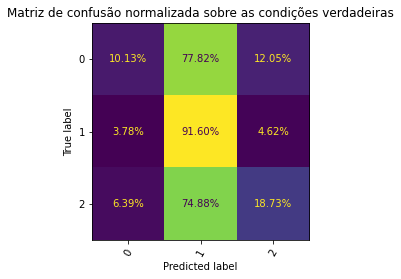

In [90]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
plt.show()

### LGBMClassifier

In [16]:
from lightgbm import LGBMClassifier

In [212]:
lgb_model = LGBMClassifier(n_jobs=-1, random_state=0)
lgb_model.fit(X_train, y_train)

lgb_preds = lgb_model.predict(X_test)

accuracy_score(y_test, lgb_preds)*100

77.83414312772791

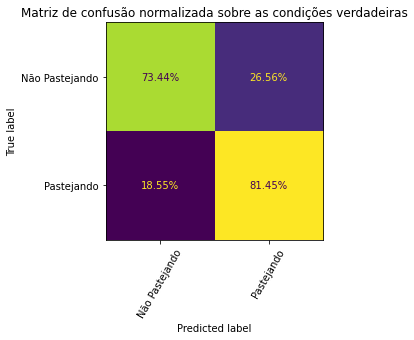

In [213]:
imprimeMatrizDeConfusão(y_test, lgb_preds, lgb_model)

#### LGB: Busca de melhores hiper parâmetros

In [95]:
def tune_lgb(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    
    print(params, '\n')
    
    lgb_Model = LGBMClassifier(learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree, random_state=0, subsample_freq=1, 
                         n_estimators=100, n_jobs=-1)
    
    auc = cross_val_score(lgb_Model, X_train, y_train, cv=3, scoring ='accuracy')
    
    return -auc.mean()

space = [(1e-3, 1e-1, 'log-uniform'), #learning rate
         (2, 512), # num_leaves
         (1, 500), # min_child_samples
         (0.05, 1.0), # subsample
         (0.1, 1.0)] # colsample bytree

In [51]:
%%time
resultados_lgb = gp_minimize(tune_lgb, space, random_state=0, verbose=1, n_calls=50, n_random_starts=10, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
[0.015335192657991574, 433, 429, 0.8548891518449193, 0.6612073271073752] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 29.7196
Function value obtained: -0.7125
Current minimum: -0.7125
Iteration No: 2 started. Evaluating function at random point.
[0.005871694001325899, 154, 29, 0.30902347985110756, 0.529898605589215] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 14.8425
Function value obtained: -0.6312
Current minimum: -0.7125
Iteration No: 3 started. Evaluating function at random point.
[0.04210536704211821, 247, 197, 0.8442748253605089, 0.40365654437554166] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 18.5394
Function value obtained: -0.7245
Current minimum: -0.7245
Iteration No: 4 started. Evaluating function at random point.
[0.01978535031094702, 190, 479, 0.1833332413920129, 0.8830785325225929] 

Iteration No: 4 ended. Evaluation done at random poi

In [52]:
resultados_lgb.x

[0.1, 512, 1, 1.0, 0.6446300002048094]

In [19]:
# Melhores hiper parâmetros para o conjunto PRO: learning_rate=0.1, num_leaves=512, min_child_samples=1, subsample=1.0, colsample_bytree=0.662, random_state=0, subsample_freq=1, n_estimators=100, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

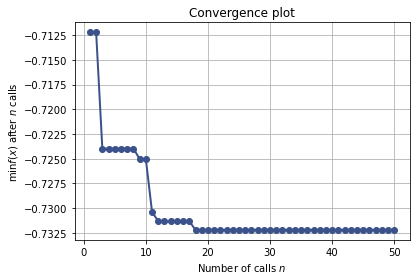

In [18]:
from skopt.plots import plot_convergence
plot_convergence(resultados_lgb)

In [36]:
# Melhores hiper parâmetros para o conjunto PNP: learning_rate=0.1, num_leaves=512, min_child_samples=88, subsample=0.729, colsample_bytree=0.671, random_state=0, subsample_freq=1, n_estimators=100, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

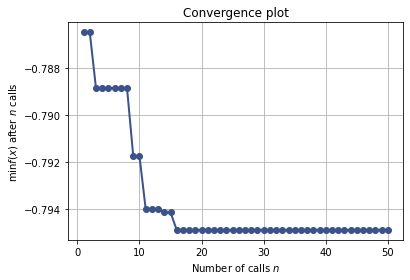

In [86]:
from skopt.plots import plot_convergence
plot_convergence(resultados_lgb)

#### LGB: Treinamento com os melhores hiper parâmetros

In [24]:
%%time
lgb_model = LGBMClassifier(learning_rate=0.1, num_leaves=512, min_child_samples=88, subsample=0.729, colsample_bytree=0.671, random_state=0, subsample_freq=1, n_estimators=100, n_jobs=-1)
lgb_model.fit(X_train, y_train)

lgb_preds = lgb_model.predict(X_test)

accuracy_score(y_test, lgb_preds)*100

CPU times: user 1min 8s, sys: 351 ms, total: 1min 8s
Wall time: 9.28 s


73.50819402124681

In [25]:
print(classification_report(y_test, lgb_preds, digits=3))

              precision    recall  f1-score   support

        Ocio      0.638     0.410     0.499     24652
  Pastejando      0.769     0.891     0.826     66502
   Ruminando      0.696     0.657     0.676     30276

    accuracy                          0.735    121430
   macro avg      0.701     0.653     0.667    121430
weighted avg      0.724     0.735     0.722    121430



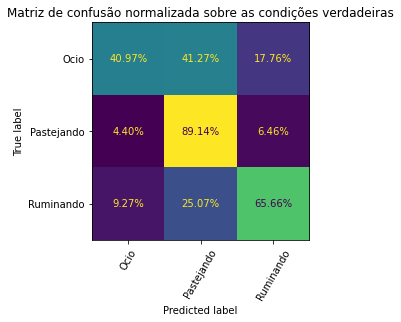

In [26]:
imprimeMatrizDeConfusão(y_test, lgb_preds, lgb_model)

In [20]:
lgb_preds = lgb_model.predict(X_train)

accuracy_score(y_train, lgb_preds)*100

76.77674380301409

### Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

#### Com Randomized Search CV

In [39]:
rf_Model = RandomForestClassifier(random_state=0, n_jobs=-1)

In [40]:
# Create the param grid
rf_param_grid = {'n_estimators':  np.arange(50, 250, 50),
               'max_features': ['auto', 'sqrt'],
               'max_depth':[50, 100, 150, None],
               'criterion': ['gini', 'entropy'],
               'min_samples_split': [2, 5, 10, 30, 50],
               'min_samples_leaf': [1, 2],
               'bootstrap': [True, False]}

In [41]:
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = rf_param_grid, cv = 3, verbose=1, random_state=0)

In [ ]:
%%time
rf_RandomGrid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [46]:
rf_RandomGrid.best_params_

{'n_estimators': 150,
 'min_samples_split': 30,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'criterion': 'entropy',
 'bootstrap': False}

In [48]:
rf_RandomGrid.best_score_

0.7361747363918738

In [50]:
preds_rf_RG = rf_RandomGrid.predict(X_test)

In [51]:
accuracy_score(y_test, preds_rf_RG)*100

74.09413128837589

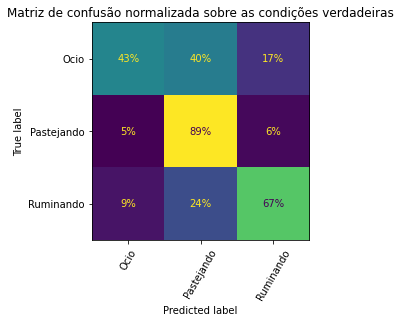

In [52]:
imprimeMatrizDeConfusão(y_test, preds_rf_RG, rf_RandomGrid)

#### RF: Busca de melhores hiper parâmetros

In [92]:
def tune_rf(params):
    n_estimators = params[0]
    max_features = params[1]
    max_depth = params[2]
    criterion = params[3]
    min_samples_split = params[4]
    min_samples_leaf = params[5]
    bootstrap = params[6]
    
    print(params, '\n')
    
    rf_Model = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, criterion=criterion, min_samples_split=min_samples_split,
                                       min_samples_leaf = min_samples_leaf, bootstrap=bootstrap, random_state=0, n_jobs=-1)
    
    auc = cross_val_score(rf_Model, X_train, y_train, cv=3, scoring ='accuracy')
    
    return -auc.mean()

space = [ np.arange(50, 250, 50), # n_estimators
         ['auto', 'sqrt'], # max_features
         [50, 100, 150, None], # max_depth
         ['gini', 'entropy'], # criterion
         [2, 5, 10, 30, 50], # min_samples_split
         [1,2,4], # min_samples_leaf
         [True, False]] # bootstrap] 

In [93]:
%%time
from skopt import forest_minimize
resultado_rf = gp_minimize(tune_rf, space, random_state=0, verbose=1, n_calls=30, n_random_starts=15, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
[150, 'sqrt', None, 'gini', 10, 2, False] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 118.0591
Function value obtained: -0.7941
Current minimum: -0.7941
Iteration No: 2 started. Evaluating function at random point.
[50, 'auto', 100, 'gini', 10, 2, True] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 31.4995
Function value obtained: -0.7960
Current minimum: -0.7960
Iteration No: 3 started. Evaluating function at random point.
[100, 'sqrt', 100, 'gini', 5, 4, False] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 78.5794
Function value obtained: -0.7949
Current minimum: -0.7960
Iteration No: 4 started. Evaluating function at random point.
[150, 'sqrt', 150, 'gini', 10, 2, True] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 85.1647
Function value obtained: -0.7974
Current minimum: -0.7974
Iteration No: 5 started. Evaluating function a

In [96]:
resultado_rf.x

[200, 'sqrt', 50, 'entropy', 30, 1, True]

In [63]:
# Melhores hiper parâmetros para o conjunto PRO: n_estimators=200, max_features='sqrt', max_depth=None, criterion='entropy', min_samples_split=10, min_samples_leaf=2 , bootstrap=True, random_state=0, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

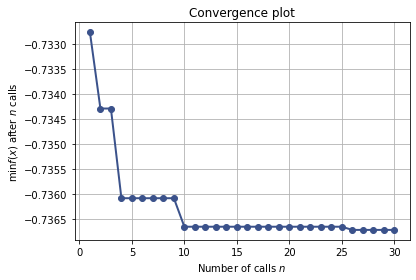

In [64]:
from skopt.plots import plot_convergence
plot_convergence(resultado_rf)

In [97]:
# Melhores hiper parâmetros para o conjunto PNP: n_estimators=200, max_features='sqrt', max_depth=50, criterion='entropy', min_samples_split=30, min_samples_leaf=1 , bootstrap=True, random_state=0, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

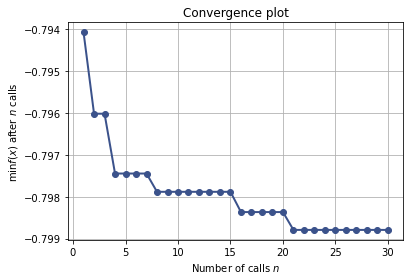

In [95]:
from skopt.plots import plot_convergence
plot_convergence(resultado_rf)

#### RF: Treinamento com os melhores hiper parâmetros

In [29]:
%%time
rf_model = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=None, criterion='entropy', 
                                  min_samples_split=10, min_samples_leaf=2 , bootstrap=True, random_state=0, n_jobs=-1)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)

CPU times: user 9min 6s, sys: 1.36 s, total: 9min 7s
Wall time: 1min 15s


In [30]:
accuracy_score(y_test, preds)*100

74.15465700403526

In [31]:
print(classification_report(y_test, preds, digits=3))

              precision    recall  f1-score   support

        Ocio      0.648     0.440     0.524     24652
  Pastejando      0.776     0.889     0.829     66502
   Ruminando      0.704     0.663     0.683     30276

    accuracy                          0.742    121430
   macro avg      0.709     0.664     0.679    121430
weighted avg      0.732     0.742     0.731    121430



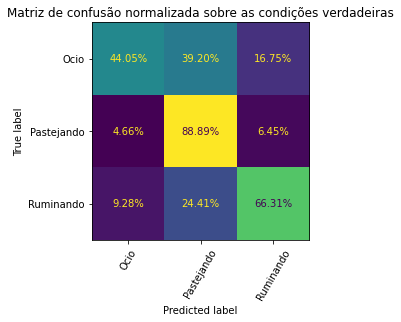

In [32]:
imprimeMatrizDeConfusão(y_test, preds, rf_model)

### Gradient Boosting

In [13]:
from xgboost import XGBClassifier

In [14]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

y_train_ordinal = ordinal_encoder.fit_transform(y_train.array.reshape(-1,1))
y_test_ordinal = ordinal_encoder.transform(y_test.array.reshape(-1,1))

In [109]:
xgb_model = XGBClassifier(use_label_encoder=False, random_state=0)
xgb_model.fit(X_train, y_train_ordinal)

[16:42:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [110]:
xgb_preds = xgb_model.predict(X_test)
xgb_preds = ordinal_encoder.inverse_transform(xgb_preds.reshape(-1,1))
accuracy_score(y_test, xgb_preds)*100

71.71539158362843

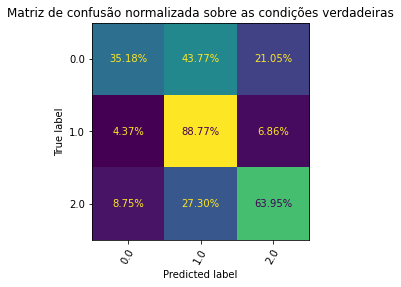

In [111]:
imprimeMatrizDeConfusão(y_test, xgb_preds, xgb_model)

#### GB: Busca de melhores hiper parâmetros

In [112]:
def tune_gb(params):
    learning_rate = params[0]
    max_depth = params[1]
    min_child_weight = params[2]
    gamma = params[3]
    colsample_bytree = params[4]
    
    print(params, '\n')
    
    gb_Model = XGBClassifier(learning_rate=learning_rate, max_depth=max_depth, min_child_weight=min_child_weight, colsample_bytree=colsample_bytree,
                             use_label_encoder=False, random_state=0, n_jobs=-1)
    
    auc = cross_val_score(gb_Model, X_train, y_train_ordinal, cv=3, scoring ='accuracy')
    
    return -auc.mean()

space = [(1e-3, 1e-1, 'log-uniform'), #learning rate
         (2, 16), # max_depth
         (1, 16), # min_child_weight
         (0.0, 0.5), # gamma
         (0.1, 1.0)] # colsample bytree

In [ ]:
%%time
resultados_gb = gp_minimize(tune_gb, space, random_state=0, verbose=1, n_calls=30, n_random_starts=10, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
[0.015335192657991574, 14, 14, 0.4236258693920628, 0.6612073271073752] 

[16:43:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:44:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:46:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 244.4441
Function value obtained: -0.7

In [ ]:
resultados_gb.x

[0.1, 16, 1, 0.0, 0.5370264280766771]

In [ ]:
# Melhores hiper parâmetros para o conjunto PRO: learning_rate=0.1, max_depth=16, min_child_weight=1, gamma=0.0, colsample_bytree=0.5370264280766771, use_label_encoder=False, random_state=0, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

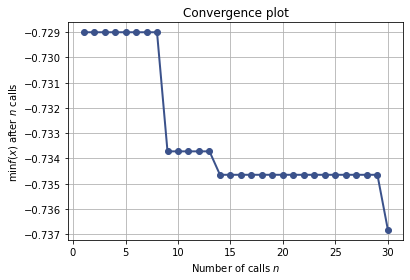

In [117]:
from skopt.plots import plot_convergence
plot_convergence(resultados_gb)

In [87]:
# Melhores hiper parâmetros para o conjunto PNP: learning_rate=0.008851671496973969, max_depth=16, min_child_weight=1, gamma=0.0, colsample_bytree=0.631278076735511, use_label_encoder=False, random_state=0, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

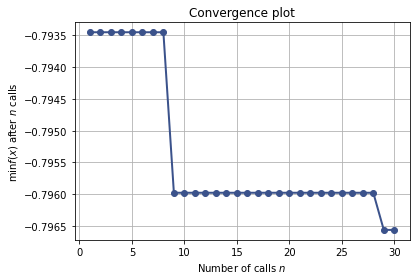

In [85]:
plot_convergence(resultados_gb)

#### GB: Treinamento com os melhores hiper parâmetros

In [24]:
%%time
gb_model = XGBClassifier(learning_rate=0.1, max_depth=16, min_child_weight=1, gamma=0.0,
                         colsample_bytree=0.5370264280766771, use_label_encoder=False, random_state=0, n_jobs=-1)

gb_model.fit(X_train, y_train_ordinal)
preds = gb_model.predict(X_test)

[19:06:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 18min 9s, sys: 13.1 s, total: 18min 22s
Wall time: 2min 32s


In [16]:
preds = ordinal_encoder.inverse_transform(preds.reshape(-1,1))
accuracy_score(y_test, preds)*100

74.29218479782591

In [17]:
print(classification_report(y_test, preds, digits=3))

              precision    recall  f1-score   support

        Ocio      0.657     0.429     0.519     24652
  Pastejando      0.775     0.894     0.830     66502
   Ruminando      0.705     0.667     0.686     30276

    accuracy                          0.743    121430
   macro avg      0.713     0.663     0.678    121430
weighted avg      0.734     0.743     0.731    121430



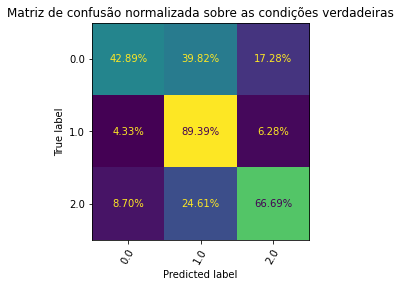

In [18]:
imprimeMatrizDeConfusão(y_test, preds, gb_model)

### SVM

In [21]:
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, random_state = 0)

In [ ]:
%%time
svc_model = SVC(kernel='linear', cache_size=5000, random_state=0) # Linear Kernel

svc_model.fit(X_train, y_train)

svc_preds = svc_model.predict(X_test)

In [ ]:
print("Acurácia:", accuracy_score(y_test, svc_preds))

###  Gaussian Naive Bayes

In [105]:
# Conjunto com todas as classes
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [106]:
from sklearn.naive_bayes import GaussianNB

In [107]:
gnb_model = GaussianNB()
gnb_preds = gnb_model.fit(X_train, y_train).predict(X_test)
print("Acurácia:", accuracy_score(y_test, gnb_preds))

Acurácia: 0.5575803093788705


### Logistic Regression

In [114]:
# Conjunto de dados PNP: Pastejando x Não Pastejando
y_pnp = y
y_pnp = y_pnp.replace(to_replace=['Agua', 'Locomovendo', 'Ocio', 'Outros','Ruminando'], value='Não Pastejando')
X_train, X_test, y_train, y_test = train_test_split(X, y_pnp, random_state = 0)

In [118]:
from sklearn.linear_model import LogisticRegression

In [128]:
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [129]:
lr_preds = lr_model.predict(X_test)

In [130]:
print("Acurácia:", accuracy_score(y_test, lr_preds))

Acurácia: 0.6313740216617915


### Redes Neurais

In [13]:
from sklearn.neural_network import MLPClassifier

In [20]:
rn_model = MLPClassifier(random_state=0)
rn_model.fit(X_train, y_train.values)

MLPClassifier(random_state=0)

In [21]:
rn_preds = rn_model.predict(X_test)

In [22]:
print("Acurácia:", accuracy_score(y_test, rn_preds)*100)

Acurácia: 69.89376595569465


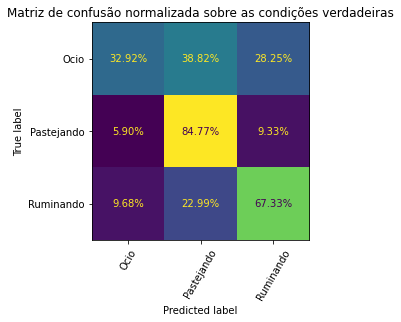

In [23]:
imprimeMatrizDeConfusão(y_test, rn_preds, rn_model)

#### RN: Busca de melhores hiper parâmetros 

In [14]:
rn_model = MLPClassifier(hidden_layer_sizes=(20,30,30,20), activation="tanh", verbose=1, learning_rate="adaptive", random_state=0)

In [15]:
%%time
rn_model.fit(X_train, y_train.values)

Iteration 1, loss = 0.82915073
Iteration 2, loss = 0.76822015
Iteration 3, loss = 0.75116423
Iteration 4, loss = 0.74117148
Iteration 5, loss = 0.73427377
Iteration 6, loss = 0.72952841
Iteration 7, loss = 0.72554214
Iteration 8, loss = 0.72235223
Iteration 9, loss = 0.71981451
Iteration 10, loss = 0.71756330
Iteration 11, loss = 0.71549285
Iteration 12, loss = 0.71370732
Iteration 13, loss = 0.71182626
Iteration 14, loss = 0.71046441
Iteration 15, loss = 0.70919036
Iteration 16, loss = 0.70809819
Iteration 17, loss = 0.70720744
Iteration 18, loss = 0.70612705
Iteration 19, loss = 0.70542479
Iteration 20, loss = 0.70443826
Iteration 21, loss = 0.70382732
Iteration 22, loss = 0.70315808
Iteration 23, loss = 0.70244693
Iteration 24, loss = 0.70190086
Iteration 25, loss = 0.70131328
Iteration 26, loss = 0.70080954
Iteration 27, loss = 0.70048176
Iteration 28, loss = 0.69977638
Iteration 29, loss = 0.69948419
Iteration 30, loss = 0.69874308
Iteration 31, loss = 0.69831578
Iteration 32, los

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 30, 30, 20),
              learning_rate='adaptive', random_state=0, verbose=1)

In [16]:
rn_preds = rn_model.predict(X_test)

In [17]:
print("Acurácia:", accuracy_score(y_test, rn_preds)*100)

Acurácia: 71.52845260643993


In [18]:
print(classification_report(y_test, rn_preds, digits=3))

              precision    recall  f1-score   support

        Ocio      0.588     0.351     0.439     24652
  Pastejando      0.756     0.890     0.818     66502
   Ruminando      0.668     0.629     0.648     30276

    accuracy                          0.715    121430
   macro avg      0.671     0.623     0.635    121430
weighted avg      0.700     0.715     0.699    121430



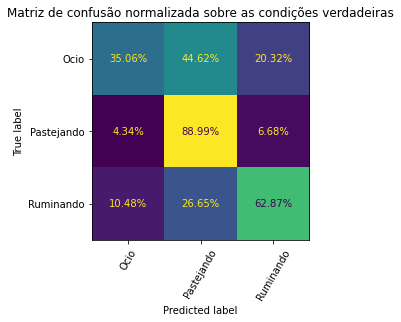

In [59]:
imprimeMatrizDeConfusão(y_test, rn_preds, rn_model)

### KNN

In [19]:
from sklearn.neighbors import KNeighborsClassifier

In [28]:
knn_model = KNeighborsClassifier(n_neighbors=10,  weights='distance', n_jobs=-1)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=10, weights='distance')

In [29]:
knn_preds = knn_model.predict(X_test)

print("Acurácia:", accuracy_score(y_test, knn_preds))

Acurácia: 0.7379230832578441


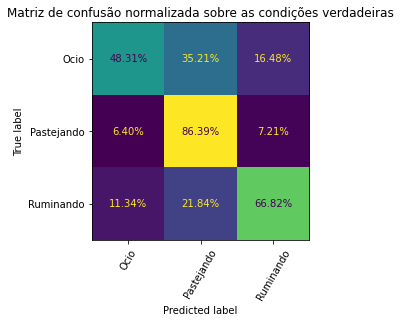

In [30]:
imprimeMatrizDeConfusão(y_test, knn_preds, knn_model)

#### KNN: Busca de melhores hiper parâmetros

In [56]:
def tune_knn(params):
    n_neighbors = params[0]
    weights = params[1]
    leaf_size = params[2]
    p = params[3]
    
    print(params, '\n')
    
    knn_Model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, leaf_size=leaf_size, p=p, n_jobs=-1)
    
    knn_Model.fit(X_train, y_train)
    
    preds = knn_Model.predict(X_test)
    
    return -accuracy_score(y_test, preds)

space = [(5, 50), #n_neighbors
         ['uniform', 'distance'], # weights
         [20,30,40,50,100], # leaf_size
         [1,2]] # p

In [ ]:
%%time
resultados_knn = gp_minimize(tune_knn, space, random_state=0, verbose=1, n_calls=30, n_random_starts=10, n_jobs=-1)

In [58]:
resultados_knn.x

[50, 'distance', 20, 2]

In [59]:
# Melhores hiper parâmetros para o conjunto PRO: n_neighbors=37, weights='distance', leaf_size=20, p=1, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

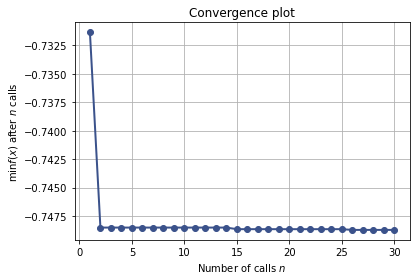

In [52]:
from skopt.plots import plot_convergence
plot_convergence(resultados_knn)

In [97]:
# Melhores hiper parâmetros para o conjunto PNP: n_neighbors=46, weights='distance', leaf_size=20, p=2, n_jobs=-1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

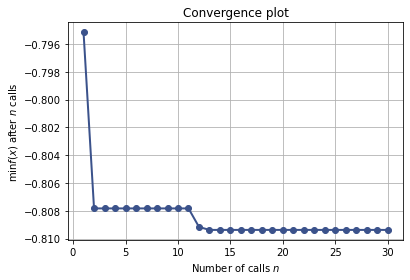

In [60]:
from skopt.plots import plot_convergence
plot_convergence(resultados_knn)

#### KNN: Treinamento com os melhores hiper parâmetros

In [20]:
%%time
knn_model = KNeighborsClassifier(n_neighbors=37, weights='distance', leaf_size=20, p=1, n_jobs=-1)

knn_model.fit(X_train, y_train)
preds = knn_model.predict(X_test)

CPU times: user 1min, sys: 211 ms, total: 1min 1s
Wall time: 9.7 s


In [21]:
accuracy_score(y_test, preds)*100

74.64053364078069

In [22]:
print(classification_report(y_test, preds, digits=3))

              precision    recall  f1-score   support

        Ocio      0.643     0.465     0.540     24652
  Pastejando      0.789     0.879     0.832     66502
   Ruminando      0.701     0.683     0.692     30276

    accuracy                          0.746    121430
   macro avg      0.711     0.676     0.688    121430
weighted avg      0.738     0.746     0.738    121430



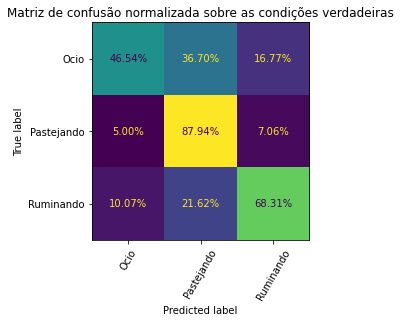

In [23]:
imprimeMatrizDeConfusão(y_test, preds, knn_model)

### Validação Exeterna com os dados do Leonardo

Leitura dos bancos de dados em DataFrame Pandas. 

In [91]:
caminho_dados_leo = 'Datasets/Leonardo/dados_pre_processados_leonardo.csv'

In [92]:
df_leo = pd.read_csv(caminho_dados_leo)

In [93]:
df_leo.head()

,SensorID,Date,Value,Voltage,X,Y,Z,Comportamento,Season_fall,Season_spring,Season_summer,magn,sma,ent,erg,pit,rol,icl
0,175810,2019-01-21 08:15:03,1.115,3.04,-0.171,1.115,0.242,Pastejando,0,0,1,1.153703,1.528,7.474426,1.771641,-12.108253,-8.719130,-81.476304
1,175810,2019-01-21 08:16:04,0.583,3.02,-0.702,0.071,0.583,Pastejando,0,0,1,0.915278,1.356,-0.089163,0.701798,-39.565868,-84.224766,-39.916535
2,175810,2019-01-21 08:16:05,0.683,3.01,-0.594,-0.026,0.683,Pastejando,0,0,1,0.905539,1.303,0.138071,0.672402,-48.959606,-92.506296,-49.007300
3,175810,2019-01-21 08:16:06,0.631,3.01,-0.706,0.059,0.631,Pastejando,0,0,1,0.948724,1.396,-0.031235,0.810140,-41.690272,-85.222926,-41.913249
4,175810,2019-01-21 08:16:07,0.604,3.01,-0.805,0.081,0.604,Pastejando,0,0,1,1.009654,1.490,-0.197988,1.039180,-36.742843,-84.254174,-37.126721


In [94]:
# Seleciona os abributos correspondentes da lista features_aplicaveis
df_leo = df_leo[features_aplicaveis]

In [95]:
df_leo = df_leo.rename({'X': 'a', 'Y': 'b', 'Z': 'c'}, axis=1)  

In [96]:
df_leo = df_leo.rename({'a': 'Y', 'b': 'Z', 'c': 'X'}, axis=1)  

In [97]:
df_leo = df_leo[features_aplicaveis]

#### Divisão entre variáveis preditoras(X) e variáveis de resposta(y)

In [98]:
# Conjunto de dados PRO: Pastejando x Ruminando x Ócio
y = df_leo.Comportamento
X = df_leo.drop('Comportamento', axis=1)

In [99]:
# Conjunto de dados PNP: Pastejando x Não Pastejando
y_pnp = y
y_pnp = y_pnp.replace(to_replace=['Ocio', 'Ruminando'], value='Não Pastejando')
y = y_pnp

In [100]:
# Para reescalar os dados
X_season = X[['Season_fall', 'Season_spring', 'Season_summer']]

X.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1, inplace=True)

columns = X.columns
index = X.index

X = sc.transform(X)

X = pd.DataFrame(X, columns=columns, index=index)

X = pd.concat([X, X_season], axis=1)

#### Com LGBMClassifier

In [232]:
%%time
lgb_preds = lgb_model.predict(X)

accuracy_score(y, lgb_preds)*100

CPU times: user 3.41 s, sys: 75.8 ms, total: 3.49 s
Wall time: 587 ms


56.711199361146484

In [233]:
print(classification_report(y, lgb_preds, digits=3))

                precision    recall  f1-score   support

Não Pastejando      0.662     0.543     0.597     81973
    Pastejando      0.478     0.602     0.533     57026

      accuracy                          0.567    138999
     macro avg      0.570     0.572     0.565    138999
  weighted avg      0.587     0.567     0.570    138999



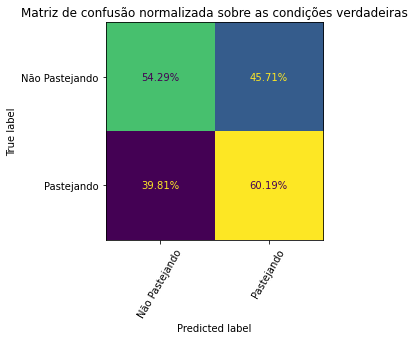

In [234]:
imprimeMatrizDeConfusão(y, lgb_preds, lgb_model)

#### Com RF

In [284]:
%%time
preds = rf_model.predict(X)

CPU times: user 3.84 s, sys: 16.2 ms, total: 3.85 s
Wall time: 531 ms


In [285]:
accuracy_score(y, preds)*100

56.797530917488615

In [286]:
print(classification_report(y, preds, digits=3))

                precision    recall  f1-score   support

Não Pastejando      0.663     0.543     0.597     81973
    Pastejando      0.479     0.604     0.534     57026

      accuracy                          0.568    138999
     macro avg      0.571     0.573     0.566    138999
  weighted avg      0.588     0.568     0.571    138999



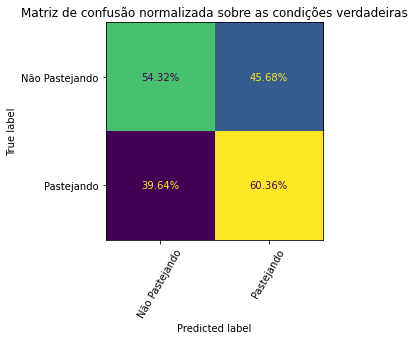

In [287]:
imprimeMatrizDeConfusão(y, preds, rf_model)

#### Com Gradient Boosting

In [288]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

y_ordinal = ordinal_encoder.fit_transform(y.array.reshape(-1,1))

In [289]:
%%time
preds = gb_model.predict(X)

CPU times: user 2.38 s, sys: 8.04 ms, total: 2.39 s
Wall time: 309 ms


In [290]:
preds = ordinal_encoder.inverse_transform(preds.reshape(-1,1))
accuracy_score(y, preds)*100

55.88745242771531

In [291]:
print(classification_report(y, preds, digits=3))

                precision    recall  f1-score   support

Não Pastejando      0.655     0.532     0.587     81973
    Pastejando      0.470     0.598     0.527     57026

      accuracy                          0.559    138999
     macro avg      0.563     0.565     0.557    138999
  weighted avg      0.579     0.559     0.562    138999



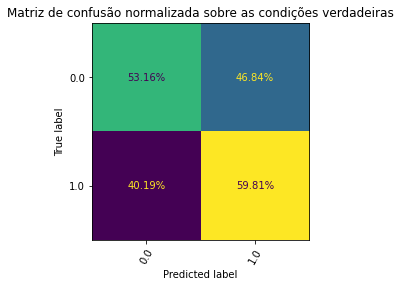

In [292]:
imprimeMatrizDeConfusão(y, preds, gb_model)

#### Com KNN

In [235]:
%%time

preds = knn_model.predict(X)

CPU times: user 3min 23s, sys: 268 ms, total: 3min 23s
Wall time: 33.9 s


In [236]:
accuracy_score(y, preds)*100

52.03202900740293

In [237]:
print(classification_report(y, preds, digits=3))

                precision    recall  f1-score   support

Não Pastejando      0.625     0.466     0.534     81973
    Pastejando      0.438     0.599     0.506     57026

      accuracy                          0.520    138999
     macro avg      0.532     0.532     0.520    138999
  weighted avg      0.549     0.520     0.522    138999



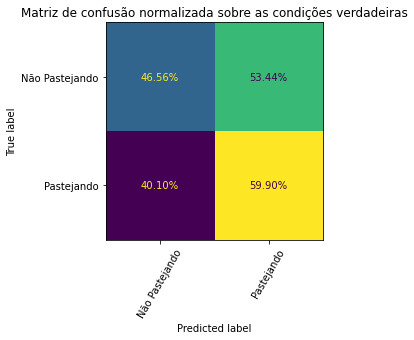

In [238]:
imprimeMatrizDeConfusão(y, preds, knn_model)

#### Com RN

In [180]:
%%time
preds = rn_model.predict(X)

CPU times: user 1.38 s, sys: 48.1 ms, total: 1.43 s
Wall time: 364 ms


In [181]:
accuracy_score(y, preds)*100

44.047798905028095

In [182]:
print(classification_report(y, preds, digits=3))

              precision    recall  f1-score   support

        Ocio      0.528     0.288     0.373     54515
  Pastejando      0.431     0.725     0.541     57026
   Ruminando      0.311     0.152     0.204     27458

    accuracy                          0.440    138999
   macro avg      0.424     0.388     0.373    138999
weighted avg      0.446     0.440     0.408    138999



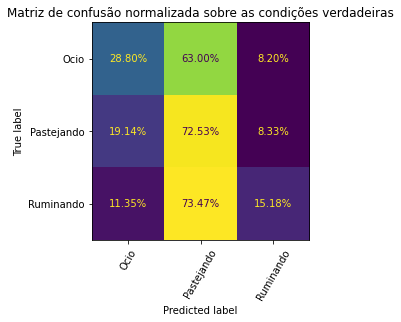

In [183]:
imprimeMatrizDeConfusão(y, preds, rn_model)

#### Com GLM

In [51]:
df = pd.concat([X, y], axis=1)

In [52]:
y, X = dmatrices( 'Comportamento ~ X + Y + Z + Season_fall + Season_spring + Season_summer + magn + sma + ent + pit + rol + icl', data=df, return_type='dataframe')

In [53]:
preds = glm_results.predict(X)

In [54]:
preds[3] = preds.median(axis=1)

In [55]:
preds = preds.reset_index(drop=True)

In [56]:
b = np.zeros((preds.shape[0], 3))

In [57]:
for i in range(preds.shape[0]):
    for j in range(3):
        if preds.loc[i,j] > preds.loc[i,3]:
            b[i,j] = 1
        else:
            b[i,j] = 0

In [58]:
preds = pd.DataFrame(b, columns=['Ocio', 'Pastejando', 'Ruminando'])

In [59]:
accuracy_score(y, preds)*100

ValueError: inconsistent shapes

In [146]:
print(classification_report(y, preds, digits=3, z))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000     54515
           1      0.366     0.773     0.497     57026
           2      0.029     0.019     0.023     27458

   micro avg      0.321     0.321     0.321    138999
   macro avg      0.132     0.264     0.173    138999
weighted avg      0.156     0.321     0.208    138999
 samples avg      0.321     0.321     0.321    138999



/home/caio/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [147]:
# Reverso de get_dummies
preds = preds.idxmax(axis=1)

In [148]:
y = y.rename(columns={"Comportamento[Ocio]" : "Ocio", "Comportamento[Pastejando]" : "Pastejando", "Comportamento[Ruminando]" : "Ruminando"})

In [149]:
y = y.idxmax(axis=1)

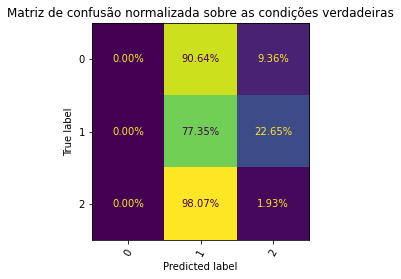

In [150]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y, preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
plt.show()

### Teste de RF em CV

In [22]:
from sklearn.model_selection import cross_val_score

def get_score(n_estimators):
    clf = RandomForestClassifier(n_estimators, random_state=0, n_jobs=-1)
    scores = cross_val_score(clf, X_train, y_train, cv=3)
    return scores.mean()


In [14]:
results = {} 
n_estimators = 100
while n_estimators < 250:
    n_estimators += 50
    results[n_estimators] = get_score(n_estimators)

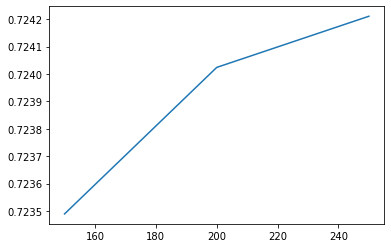

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

### Lidando com dados desbalanceados

In [308]:
import seaborn as sns

In [309]:
df.Comportamento.value_counts()

Pastejando    332512
Ruminando     151381
Ocio          123257
Name: Comportamento, dtype: int64

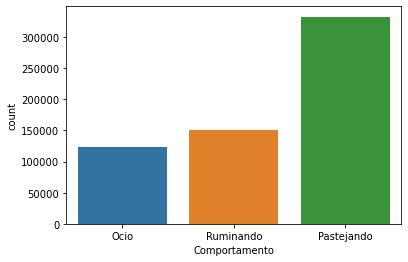

In [151]:
ax = sns.countplot(x="Comportamento", data=df)

In [152]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=150,
                              min_samples_split=30,
                              min_samples_leaf=1,
                              max_features='sqrt',
                              max_depth=100,
                              criterion='entropy',
                              bootstrap=False,
                              n_jobs=-1,
                              random_state=0)
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [153]:
accuracy_score(y_test, preds)*100

74.16462434448046

In [156]:
print (classification_report(y_test, preds))

              precision    recall  f1-score   support

        Ocio       0.65      0.43      0.52     30838
  Pastejando       0.78      0.89      0.83     83380
   Ruminando       0.70      0.67      0.68     37570

    accuracy                           0.74    151788
   macro avg       0.71      0.66      0.68    151788
weighted avg       0.73      0.74      0.73    151788



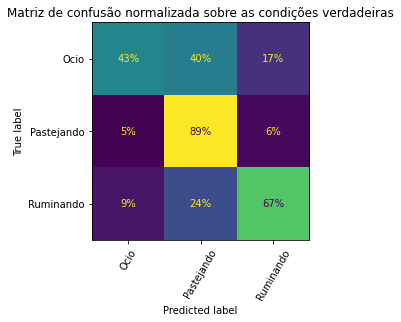

In [157]:
imprimeMatrizDeConfusão(y_test, preds, model)

#### Aplicando NearMiss

In [18]:
from imblearn.under_sampling import NearMiss
nr = NearMiss()

In [165]:
X, y = nr.fit_resample(X, y)

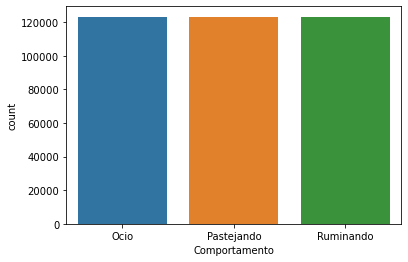

In [166]:
ax = sns.countplot(x=y)

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [168]:
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [169]:
accuracy_score(y_test, preds)*100

68.94086085479701

In [170]:
print (classification_report(y_test, preds))

              precision    recall  f1-score   support

        Ocio       0.66      0.61      0.64     30976
  Pastejando       0.70      0.73      0.72     30906
   Ruminando       0.70      0.73      0.72     30561

    accuracy                           0.69     92443
   macro avg       0.69      0.69      0.69     92443
weighted avg       0.69      0.69      0.69     92443



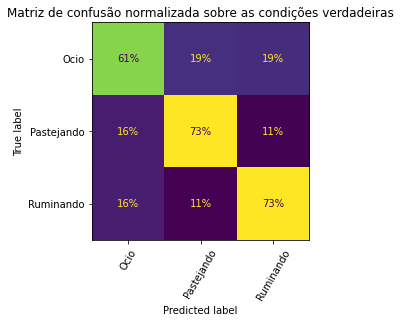

In [171]:
imprimeMatrizDeConfusão(y_test, preds, model)

#### Aplicando o SMOTE

In [302]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()

In [303]:
X = df.drop("Comportamento", axis = 1)
y = df.Comportamento

In [304]:
# Visualizando a quantidade de dados por classe
y.value_counts()

Pastejando    332512
Ruminando     151381
Ocio          123257
Name: Comportamento, dtype: int64

In [305]:
X, y = smt.fit_resample(X, y)

In [306]:
# Visualizando a quantidade de dados por classe
y.value_counts()

Ocio          332512
Ruminando     332512
Pastejando    332512
Name: Comportamento, dtype: int64

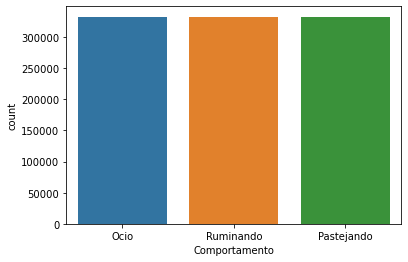

In [310]:
ax = sns.countplot(x=y)

In [311]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [312]:
# Para reescalar os dados
from sklearn.preprocessing import StandardScaler

X_train_season = X_train[['Season_fall', 'Season_spring', 'Season_summer']]
X_test_season =  X_test[['Season_fall', 'Season_spring', 'Season_summer']]

X_train.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1, inplace=True)
X_test.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1, inplace=True)

columns = X_train.columns
index_train = X_train.index
index_test = X_test.index


sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

X_train = pd.DataFrame(X_train, columns=columns, index=index_train)
X_test = pd.DataFrame(X_test, columns=columns, index=index_test)

X_train = pd.concat([X_train, X_train_season], axis=1)
X_test = pd.concat([X_test, X_test_season], axis=1)

In [65]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=150,
                              min_samples_split=30,
                              min_samples_leaf=1,
                              max_features='sqrt',
                              max_depth=100,
                              criterion='entropy',
                              bootstrap=False,
                              n_jobs=-1,
                              random_state=0)
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [66]:
accuracy_score(y_test, preds)*100

76.60595707824078

In [67]:
print (classification_report(y_test, preds))

              precision    recall  f1-score   support

        Ocio       0.76      0.72      0.74     83256
  Pastejando       0.75      0.80      0.77     83127
   Ruminando       0.79      0.78      0.78     83001

    accuracy                           0.77    249384
   macro avg       0.77      0.77      0.77    249384
weighted avg       0.77      0.77      0.77    249384



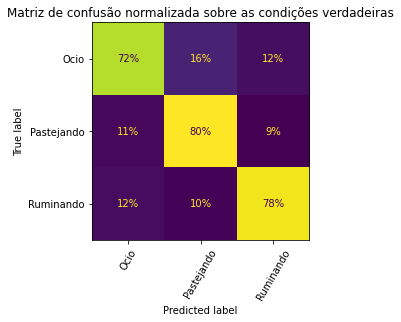

In [69]:
imprimeMatrizDeConfusão(y_test, preds, model)